50 50


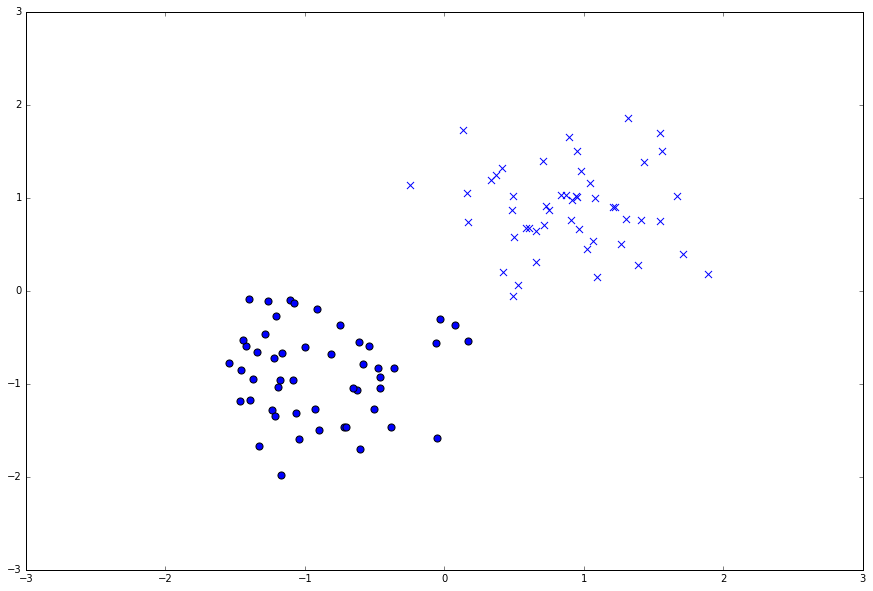

In [146]:
# Might be very buggy, ported from simplified SMO algorithm, kernel is gaussian
import csv
import matplotlib.pyplot as plt
import random
from math import exp, log

num_epochs = 5
ax_size = (-3, 3, -3, 3)
data_file_name = 'dataset1.csv'
X = []
Y = []
Xpos = []
Xneg = []
Ypos = []
Yneg = []

csv_reader = csv.DictReader(open(data_file_name))
for row in csv_reader:
    x = (float(row['x1']), float(row['x2']))
    y = float(row['y'])
    X.append(x)
    y = -1.0 if y == 0 else 1.0
    Y.append(y)

xy = zip(X, Y)
random.shuffle(xy)
X, Y = zip(*xy)

for x, y in xy:
    Xneg.append(x) if y == -1.0 else Xpos.append(x)
    Yneg.append(y) if y == -1.0 else Ypos.append(y)
    
print len(Xpos), len(Xneg)

plt.figure(figsize=(15, 10))
plt.axis(ax_size)
x1pos, x2pos = zip(*Xpos)
x1neg, x2neg = zip(*Xneg)
plt.scatter(x1pos, x2pos, marker=('o'), s=50)
plt.scatter(x1neg, x2neg, marker=('x'), s=50)
plt.show()

split_idx = int(0.8 * len(Xpos))
X_train = Xpos[:split_idx]
Y_train = Ypos[:split_idx]
X_test = Xpos[split_idx:]
Y_test = Ypos[split_idx:]

split_idx = int(0.8 * len(Xneg))
X_train += Xneg[:split_idx]
Y_train += Yneg[:split_idx]
X_test += Xneg[split_idx:]
Y_test += Yneg[split_idx:]

random.shuffle(X_train)
random.shuffle(X_test)
random.shuffle(Y_train)
random.shuffle(Y_test)

In [154]:
# Gaussian Kernel
kernel = lambda x1, x2, sigma: exp(-sum([(float(a - b) ** 2) for a, b in zip(x1, x2)])/(2 * (sigma ** 2)))
SIGMA = 0.8
C = 1
model = None

class SVMModel:
    def __init__(self, _x, _y, _kernel, _b, _alphas, _w, _sigma):
        self.x = _x
        self.y = _y
        self.kernel = _kernel
        self.b = _b
        self.alphas = _alphas
        self.w = _w # This will be a row vector not a column vector
        self.sigma = _sigma

In [155]:
def train(_X, _Y, _kernel, _sigma, _C, epochs):
    tol = 0.001
    m = len(_X)
    n = len(_X[0])
    alphas = [0 for _ in range(m)]
    b = 0
    E = [0 for _ in range(m)]
    passes = 0
    eta = 0
    L = 0
    H = 0
    K = [[0 for _j in range(m)] for _i in range(m)]
    for i in range(m):
        for j in range(i, m):
            K[i][j] = K[j][i] = _kernel(_X[i], _X[j], _sigma)
    
    print "Training ..."
    while passes < epochs:
        num_changed_alphas = 0
        for i in range(m):
            tmp = [(alphas[_j] * _Y[_j] * K[_j][i]) for _j in range(m)]
            E[i] = b + sum(tmp) - Y[i]
            if (Y[i] * E[i] < -tol and alphas[i] < _C) or (Y[i] * E[i] > tol and alphas[i] > 0):
                
                j = random.randint(0 , m - 1)
                while j == i:
                    j = random.randint(0 , m - 1)
                
                tmp = [(alphas[_j] * _Y[_j] * K[_j][j]) for _j in range(m)]
                E[j] = b + sum(tmp) - Y[j]
                
                alpha_i_old = alphas[i];
                alpha_j_old = alphas[j];
                
                if Y[i] == Y[j]:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                else:
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                
                if L == H:
                    continue
                    
                eta = 2 * K[i][j] - K[i][i] - K[j][j]
                if eta >= 0:
                    conitnue
                    
                alphas[j] = alphas[j] - (Y[j] * (E[i] - E[j])) / eta;
                
                alphas[j] = min(H, alphas[j]);
                alphas[j] = max(L, alphas[j]);
                
                if abs(alphas[j] - alpha_j_old) < tol:
                    alphas[j] = alpha_j_old
                    continue
                
                alphas[i] = alphas[i] + Y[i] * Y[j] * (alpha_j_old - alphas[j])
                b1 = b - E[i] - Y[i] * (alphas[i] - alpha_i_old) * K[i][j] - Y[j] * (alphas[j] - alpha_j_old) * K[i][j]
                b2 = b - E[j] - Y[i] * (alphas[i] - alpha_i_old) * K[i][j] - Y[j] * (alphas[j] - alpha_j_old) * K[j][j]
                
                if 0 < alphas[i] < C:
                    b = b1
                elif 0 < alphas[j] < C:
                    b = b2
                else:
                    b = (b1 + b2)/2
                    
                num_changed_alphas = num_changed_alphas + 1
        
        if num_changed_alphas == 0:
            passes += 1
        else:
            passes = 0

    tmp = [alphas[_j] * _Y[_j] for _j in range(m)]
    w = [0.0 for _j in range(n)]
    _Xapos = []
    _Yapos = []
    _alphapos = []
    for _i, alpha in enumerate(alphas):
        if alpha > 0:
            _Xapos.append(_X[_i])
            _Yapos.append(_Y[_i])
            _alphapos.append(alphas[_i])
    
    for _i in range(n):
        for _j in range(m):
            w[_i] += tmp[_j] * _X[_j][_i]
    print "Done"
    return SVMModel(_Xapos, _Yapos, _kernel, b, _alphapos, w, _sigma)

In [156]:
model = train(_X=X_train, _Y=Y_train, _kernel=kernel, _sigma=SIGMA, _C=C, epochs=1000)

Training ...
Done


In [157]:
def predict(_model, _x):
    preds = [0 for _ in range(len(_x))]
    for i in range(len(_x)):
        prediction = 0
        for j in range(len(model.x)):
            prediction = prediction + model.alphas[j] * model.y[j] * model.kernel(_x[i], model.x[j], model.sigma)
        preds[i] = prediction + model.b;
        preds[i] = -1.0 if preds[i] < 0 else 1.0
    return preds

In [158]:
predictions = predict(model, X_test)
print predictions
print Y_test

[1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0]
[1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0]


In [159]:
corr = 0.0
for i in range(len(Y_test)):
    corr += 1.0 if Y_test[i] == predictions[i] else 0.0
print "Accuracy: " + str(corr/len(Y_test))

Accuracy: 0.4


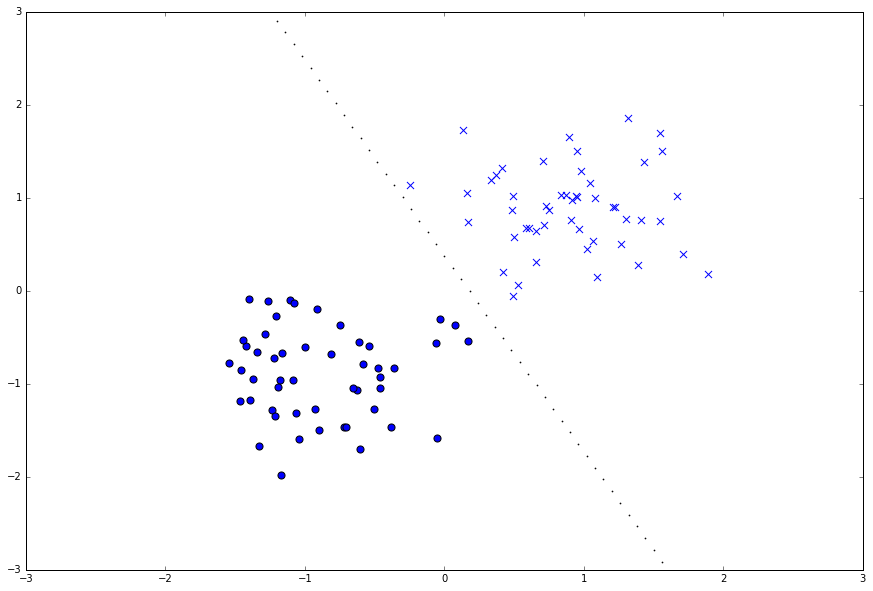

In [160]:
xp = [(-3 + x * (6.0/100)) for x in range(100)]
yp = [(-(model.w[0] * _xp + model.b)/model.w[1]) for _xp in xp]

plt.figure(figsize=(15, 10))
plt.axis(ax_size)
x1pos, x2pos = zip(*Xpos)
x1neg, x2neg = zip(*Xneg)
plt.scatter(x1pos, x2pos, marker=('o'), s=50)
plt.scatter(x1neg, x2neg, marker=('x'), s=50)
plt.scatter(xp, yp, c='r', marker=('.'), s=2)
plt.show()